In [ ]:
# Download the single-cell sequencing data
!mkdir temporary_data
!mkdir temporary_data/example_codebook_design
!wget https://data.nemoarchive.org/biccn/grant/u19_zeng/zeng/transcriptome/scell/10x_v3/mouse/processed/analysis/10X_cells_v3_AIBS/matrix.mtx.gz -O temporary_data/example_codebook_design/matrix.mtx.gz
!gzip -d temporary_data/example_codebook_design/matrix.mtx.gz -f
!wget https://data.nemoarchive.org/biccn/grant/u19_zeng/zeng/transcriptome/scell/10x_v3/mouse/processed/analysis/10X_cells_v3_AIBS/features.tsv.gz -O temporary_data/example_codebook_design/features.tsv.gz
!gzip -d temporary_data/example_codebook_design/features.tsv.gz -f
# Download the mouse transcriptome data
!wget http://ftp.ensembl.org/pub/release-104/fasta/mus_musculus/cdna/Mus_musculus.GRCm39.cdna.all.fa.gz -O temporary_data/example_codebook_design/Mus_musculus.GRCm39.cdna.all.fa.gz
!gzip -d temporary_data/example_codebook_design/Mus_musculus.GRCm39.cdna.all.fa -f
!wget http://ftp.ensembl.org/pub/release-104/fasta/mus_musculus/ncrna/Mus_musculus.GRCm39.ncrna.fa.gz -O temporary_data/example_codebook_design/Mus_musculus.GRCm39.ncrna.fa.gz
!gzip -d temporary_data/example_codebook_design/Mus_musculus.GRCm39.ncrna.fa -f

In [41]:
# Input files
mtx_file = 'temporary_data/example_codebook_design/matrix.mtx'
features_file = 'temporary_data/example_codebook_design/features.tsv'
transcriptome_cdna_file = 'temporary_data/example_codebook_design/Mus_musculus.GRCm39.cdna.all.fa'
transcriptome_ncrna_file = 'temporary_data/example_codebook_design/Mus_musculus.GRCm39.ncrna.fa'
genes_of_interest_file = 'data/example_codebook_design/genes_Zhang_MOp.csv'
# Output file
cluster_gene_exp_file = 'temporary_data/example_codebook_design/cluster_gene_exp.npz'

In [2]:
import pandas as pd
import scanpy as sc

In [4]:
%%time
adata = sc.read_mtx(mtx_file)
adata = adata.transpose() # The matrix has to be transposed because the genes and cells are fipped

CPU times: user 17min 50s, sys: 13.8 s, total: 18min 4s
Wall time: 18min


In [5]:
features = pd.read_csv(features_file, sep='\t', header=None)
adata.var['gene_ids'] = list(features[0])
adata.var['gene_symbols'] = list(features[1])
adata.var = adata.var.set_index('gene_symbols')
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 176584 × 31053
    var: 'gene_ids'

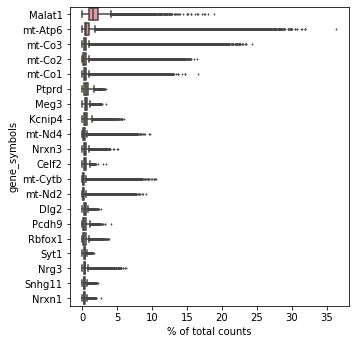

In [6]:
# Preprocessing
# Show the highest expressed genes
sc.pl.highest_expr_genes(adata, n_top=20, )

In [7]:
# Save the raw state before cleaning the data
adata.raw = adata

In [8]:
# Filter out rare genes and cells express few genes
sc.pp.filter_cells(adata, min_genes=2000)
sc.pp.filter_genes(adata, min_cells=20)
adata

AnnData object with n_obs × n_vars = 109217 × 25049
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

In [9]:
# annotate the group of mitochondrial genes as 'mt'
# High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), 
# possibly because of loss of cytoplasmic RNA from perforated cells.
adata.var['mt'] = adata.var_names.str.startswith('mt-')  
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

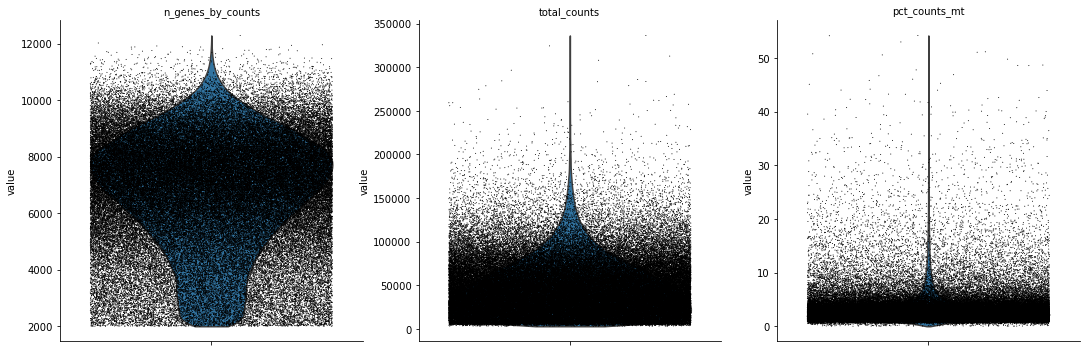

In [10]:
# A violin plot of some of the computed quality measures:
# - the number of genes expressed in the count matrix
# - the total counts per cell
# - the percentage of counts in mitochondrial genes
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

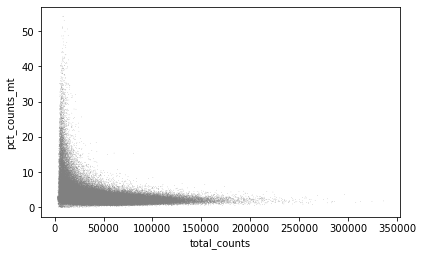

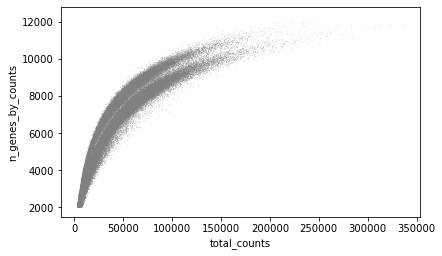

In [11]:
# Plot the distributions of gene counts
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [12]:
# Filter
adata = adata[adata.obs.n_genes_by_counts < 12000, :]
adata = adata[adata.obs.total_counts < 250000, :]
adata = adata[adata.obs.pct_counts_mt < 10, :]

In [13]:
# Total-count normalize (library-size correct) the data matrix to 10,000 reads per cell
sc.pp.normalize_total(adata, target_sum=1e4)

/home/xingjie/.local/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [14]:
# Logarithmize the data
sc.pp.log1p(adata)

In [15]:
# Identify highly-variable genes.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

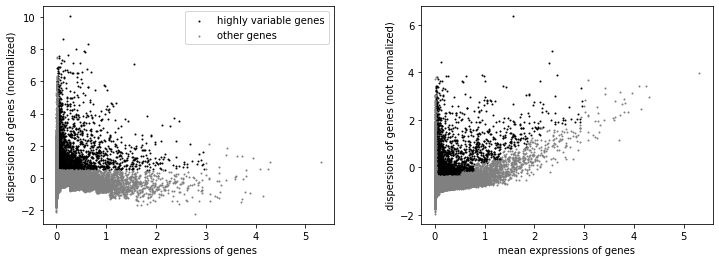

In [16]:
# Plot the highly variable genes
sc.pl.highly_variable_genes(adata)

In [17]:
# Filter out genes that are not highly variable
adata = adata[:, adata.var.highly_variable]

In [18]:
%%time
# Regress out effects of total counts per cell
sc.pp.regress_out(adata, ['total_counts'])

CPU times: user 24min 19s, sys: 1h 13min 36s, total: 1h 37min 56s
Wall time: 2min 9s


In [19]:
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

In [20]:
# Principal component analysis
sc.tl.pca(adata, svd_solver='arpack')

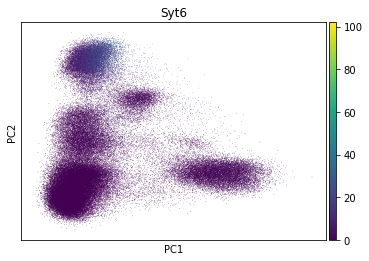

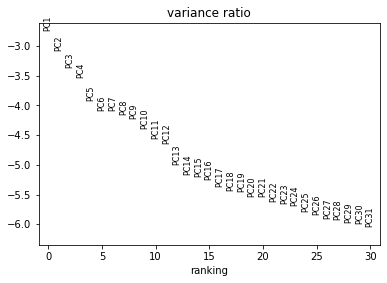

In [21]:
# Plot the PCA results
sc.pl.pca(adata, color='Syt6')
sc.pl.pca_variance_ratio(adata, log=True)

In [22]:
%%time
# Computing the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

CPU times: user 41.1 s, sys: 41.3 s, total: 1min 22s
Wall time: 23.7 s


In [23]:
# Embed with UMAP
sc.tl.umap(adata)

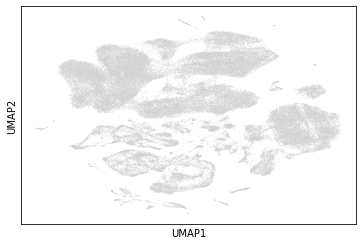

In [24]:
# Plot the UMAP
sc.pl.umap(adata)

In [25]:
# Clustering the neighborhood graph
sc.tl.leiden(adata)

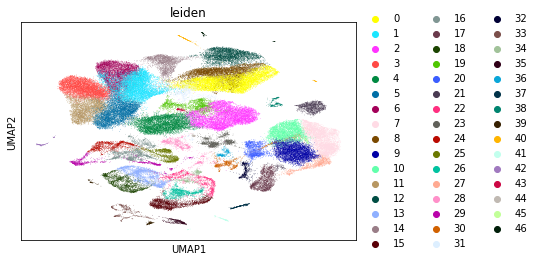

In [26]:
# Plot the clusters
sc.pl.umap(adata, color='leiden')

In [27]:
# Load the genes of interest
genes_zhang = pd.read_csv(genes_of_interest_file)
genes_of_interest = list(genes_zhang['gene'])

In [28]:
# Load the transcriptome of mice
import MERFISH_probe_design.IO.file_io as fio
transcriptome = fio.load_fasta_into_df(transcriptome_cdna_file)
transcriptome = transcriptome.append(fio.load_fasta_into_df(transcriptome_ncrna_file))
transcriptome

,id,description,sequence
0,ENSMUST00000178537.2,ENSMUST00000178537.2 cdna chromosome:GRCm39:6:...,GGGACAGGGGGC
1,ENSMUST00000178862.2,ENSMUST00000178862.2 cdna chromosome:GRCm39:6:...,GGGACTGGGGGGGC
2,ENSMUST00000196221.2,ENSMUST00000196221.2 cdna chromosome:GRCm39:14...,ATGGCATAT
3,ENSMUST00000179664.2,ENSMUST00000179664.2 cdna chromosome:GRCm39:14...,ATGGCATATCA
4,ENSMUST00000177564.2,ENSMUST00000177564.2 cdna chromosome:GRCm39:14...,ATCGGAGGGATACGAG
...,...,...,...
21654,ENSMUST00020183577.1,ENSMUST00020183577.1 ncrna chromosome:GRCm39:2...,CTATAAAAGATGTAACAGATGCAAACTGTAACACAAGGGCCATTAA...
21655,ENSMUST00020183414.1,ENSMUST00020183414.1 ncrna chromosome:GRCm39:2...,TCCACGCCCCCCCCCCCCCCCCCCCCCCCCGTCAAGCAAGCCTTTG...
21656,ENSMUST00020182515.1,ENSMUST00020182515.1 ncrna chromosome:GRCm39:2...,GACACTAAACTGTGTGGGGTCTAAGTTTTGAAGTGCATATTTTTGA...
21657,ENSMUST00020182784.1,ENSMUST00020182784.1 ncrna chromosome:GRCm39:2...,TGGCAAGGCTGACATAGCTTTTACTGATCTGTCTGTTTAGTGAGTG...


In [29]:
# Get the lengths of transcripts, which is necessary for FPKM calculation
t_lengths = []
for t in genes_zhang['transcript']:
    t_len = len(transcriptome[transcriptome['id'].str.contains(t)].iloc[0]['sequence'])
    t_lengths.append(t_len)

In [30]:
t_lengths

[3727,
 1318,
 2098,
 1162,
 2035,
 2551,
 7266,
 3761,
 3047,
 5454,
 2232,
 3959,
 5054,
 2464,
 1722,
 2958,
 1968,
 8111,
 3965,
 2419,
 1701,
 5349,
 4023,
 2535,
 3879,
 3705,
 1431,
 4180,
 1679,
 2201,
 2902,
 6572,
 2742,
 2670,
 3648,
 2140,
 1641,
 1816,
 2424,
 5310,
 6004,
 3785,
 4012,
 3539,
 1396,
 7111,
 2858,
 2983,
 2535,
 5676,
 3554,
 1416,
 1662,
 4007,
 4867,
 6457,
 1755,
 5658,
 7143,
 6701,
 4639,
 2859,
 2695,
 4182,
 8121,
 1355,
 8784,
 1827,
 1926,
 662,
 4747,
 6886,
 2687,
 10208,
 2662,
 2965,
 3832,
 4970,
 2880,
 4364,
 5565,
 4632,
 2188,
 3977,
 6895,
 3477,
 3523,
 5647,
 12348,
 1851,
 2648,
 2390,
 2423,
 3655,
 7431,
 6930,
 3856,
 3117,
 2715,
 2503,
 3831,
 6006,
 9278,
 3437,
 5256,
 3005,
 5847,
 8403,
 4089,
 2548,
 2023,
 5551,
 3188,
 1282,
 1910,
 2743,
 4901,
 6464,
 996,
 3953,
 1605,
 3229,
 3090,
 5374,
 4610,
 3673,
 6390,
 7417,
 8805,
 4567,
 1043,
 10123,
 1959,
 4532,
 3791,
 3325,
 4222,
 2477,
 3568,
 1593,
 2815,
 2579,
 1675

In [31]:
# Get the raw data without gene filtering
adata_raw = adata.raw.to_adata()

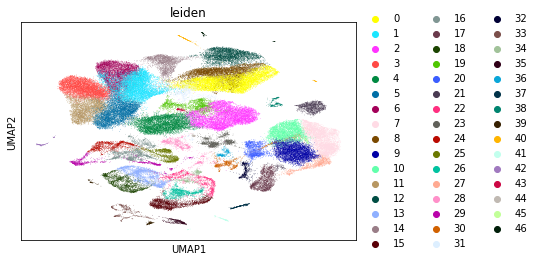

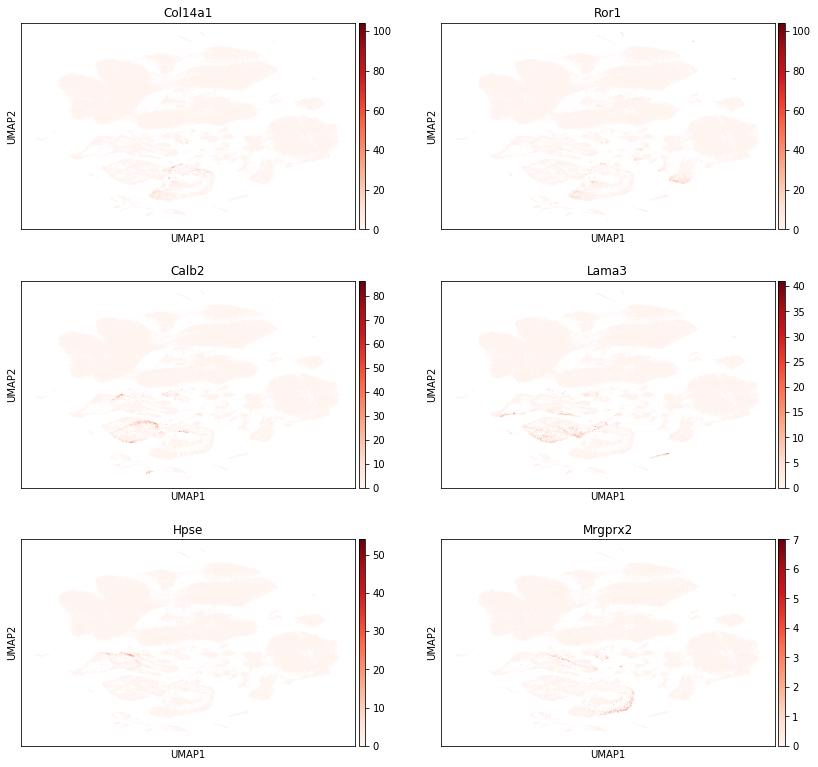

In [32]:
# Plot the expressions of a few random genes of interest
import numpy as np
sc.pl.umap(adata_raw, color='leiden', ncols=1)
sc.pl.umap(adata_raw, color=np.random.choice(genes_of_interest, size=6, replace=False), color_map='Reds', ncols=2)

In [33]:
# Create a matrix of gene expression levels in each cluster
# The matrix is N_clusters x N_genes
# Each element is the average count of expression of a gene belong to the cluster
cluster_labels = np.unique(np.array(adata_raw.obs['leiden']))
N_clusters = len(cluster_labels)
N_goi = len(genes_of_interest)

#cluster_gene_exp = np.zeros((N_clusters, N_goi), dtype=float)

In [38]:
%%time
# Fill the expression matrix with FPKMs
# This simple implementation is slow. So speed it up by parallel processing
insert_length = 90

cluster_ids = list(range(N_clusters))

def fill_cluster_gene_exp(i):
    adata_cluster = adata_raw[adata_raw.obs['leiden'] == cluster_labels[i]]
    cluster_read_count = adata_cluster.X.sum()
    cluster_gene_fpkms = []
    
    for j in range(N_goi):
        adata_cg = adata_cluster[:, adata_cluster.var.index == genes_of_interest[j]]
        cg_read_count = adata_cg.X.sum()
        fpkm = cg_read_count / (t_lengths[j] - insert_length + 1) / cluster_read_count * 1e9
        #print(cluster_labels[i], '\t', genes_of_interest[j], '\t', fpkm)
        cluster_gene_fpkms.append(fpkm)
    
    print('Finished cluster', cluster_labels[i])
    return cluster_gene_fpkms
        
from multiprocessing import Pool

with Pool(24) as p:
    cluster_gene_exp = np.array(p.map(fill_cluster_gene_exp, cluster_ids))
    

Finished cluster 29
Finished cluster 26
Finished cluster 24
Finished cluster 20
Finished cluster 25
Finished cluster 27
Finished cluster 28
Finished cluster 21
Finished cluster 22
Finished cluster 19
Finished cluster 37
Finished cluster 34
Finished cluster 18
Finished cluster 
32Finished cluster 35
Finished cluster 14
Finished cluster 33
Finished cluster 40
Finished cluster 36
Finished cluster 41
Finished cluster 39
Finished cluster 44
Finished cluster 17
Finished cluster 38
Finished cluster 23
Finished cluster 42
Finished cluster 46
Finished cluster 45
Finished cluster 43
Finished cluster 30
Finished cluster 31
Finished cluster 13Finished cluster
 16
Finished cluster 15
Finished cluster 12
Finished cluster 11
Finished cluster 10
Finished cluster 3
Finished cluster 6
Finished cluster 8
Finished cluster 7
Finished cluster 9
Finished cluster 1
Finished cluster 2
Finished cluster 4
Finished cluster 5
Finished cluster 0
CPU times: user 160 ms, sys: 986 ms, total: 1.15 s
Wall time: 1min 21s

In [39]:
cluster_gene_exp

array([[4.85625054e-01, 1.95600859e+00, 3.92030058e-02, ...,
        5.20863139e+01, 4.80276801e-01, 1.08697291e+01],
       [4.87321611e-01, 2.99963198e+00, 2.14538146e-02, ...,
        2.48415343e+01, 1.54194250e+00, 5.18678019e+00],
       [5.37605932e-01, 2.99736319e+00, 5.48198167e-01, ...,
        3.45144539e+01, 4.56598038e+00, 2.72447737e+01],
       ...,
       [1.40215357e+00, 2.91344220e+00, 2.10471423e-01, ...,
        2.78953078e+01, 3.62085770e+00, 3.01573513e+01],
       [1.17304028e+00, 2.05555970e+00, 4.07431822e-02, ...,
        4.26936461e+01, 6.03063204e-01, 1.34261908e+01],
       [4.78351665e-01, 4.41186884e+00, 2.49626033e-01, ...,
        2.99582672e+01, 7.70646752e-01, 5.76751598e+01]])

Text(0.5, 0, 'log(FPKM + 1)')

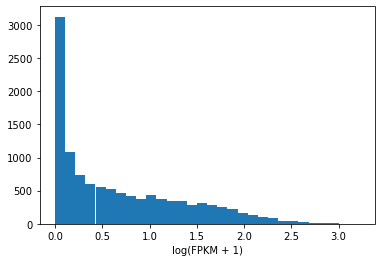

In [58]:
# Plot the distribution of FPKMs
import matplotlib.pyplot as plt
plt.hist(np.log10(cluster_gene_exp.flatten() + 1), bins=30)
plt.xlabel('log(FPKM + 1)')

In [59]:
# Save the expression matrix
np.savez(cluster_gene_exp_file, cluster_gene_exp)